# Baseline workflow

This notebook presents a computational workflow to detect trees from aerial imagery with a train/test split of image tiles based on uniform sampling.

In order to avoid issues with relative paths, let us first of all change the working directory to the repository's root

In [ ]:
%cd ..

/home/martibosch/data-science/detectree-examples


In [ ]:
import glob
import os
import random
from os import path

import detectree as dtr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from rasterio import plot
from sklearn import model_selection

from detectree_examples import make_confusion_df, make_response_tiles

figwidth, figheight = plt.rcParams["figure.figsize"]
%matplotlib inline

Let us now use the Makefile at the root of this repository ensure that we have the required data input data - i.e., the tiles from [Zurich's RGB orthophoto of summer 2014/15](https://www.geolion.zh.ch/geodatensatz/2831) that lie within Zurich's municipal boundaries - has been downloaded (see [the background notebook](https://github.com/martibosch/detectree-example/blob/main/notebooks/background.ipynb) for more details).

In [ ]:
!make tiles

make: Nothing to be done for 'tiles'.


## Train/test split

In order to select which image tiles are to be used to train the classifier, we will use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function provided by scikit-learn, setting the proportion of tiles to be used in the training to 1%.

In [ ]:
img_filepaths = glob.glob("data/interim/tiles/*.tif")

train_filepaths, test_filepaths = model_selection.train_test_split(
    img_filepaths, train_size=0.01
)

print("Num of training tiles:", len(train_filepaths))
print("Num of test tiles:", len(test_filepaths))

Num of training tiles: 3
Num of test tiles: 347


## Interlude: computing the responses from LIDAR data

Since detectree uses a supervised learning approach, we need to manually provide the responses (i.e., binary images representing the ground-truth tree/non-tree masks) for the training tiles so that the tree/non-tree pixel classifier can be trained.

There are many ways to obtain such masks, the most straight-forward being manual edition in a raster graphics editor software such as [GIMP](https://www.gimp.org/). In the case of this example dataset, the ground-truth masks can be extracted from [Zurich's 2014 LIDAR dataset](https://www.geolion.zh.ch/geodatensatz/show?gdsid=343). Such task is accomplished in the two cells below, whose content is out of the scope of detectree.

In [ ]:
!make download_lidar_shp

make: Nothing to be done for 'download_lidar_shp'.


In [ ]:
lidar_gdf = gpd.read_file("data/raw/lidar/lidar2014.shp")
# lidar_gdf.iloc[:20].plot(edgecolor=(0,0,0))

response_dir = "data/interim/response-tiles"
if not path.exists(response_dir):
    os.mkdir(response_dir)

response_filepaths = []
for train_filepath in train_filepaths:
    response_filepath = make_response_tiles.make_response_tile(
        train_filepath, lidar_gdf, "data/raw/lidar", response_dir
    )
    response_filepaths.append(response_filepath)

Let us now plot side by side the training tiles (left) and the LIDAR-based ground-truth masks.

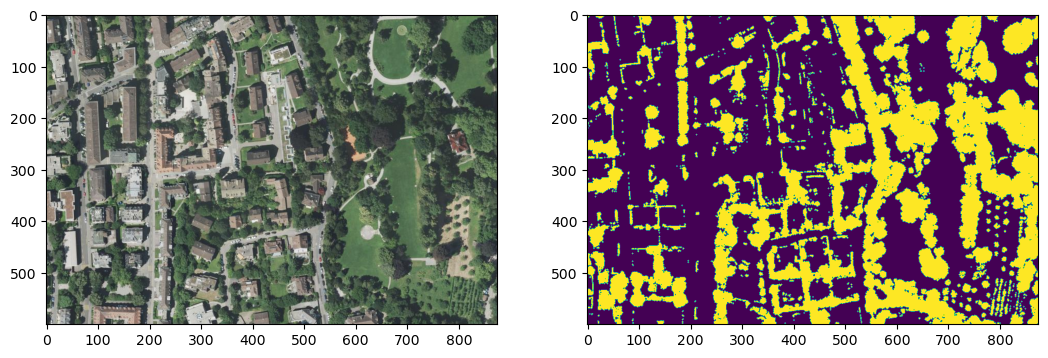

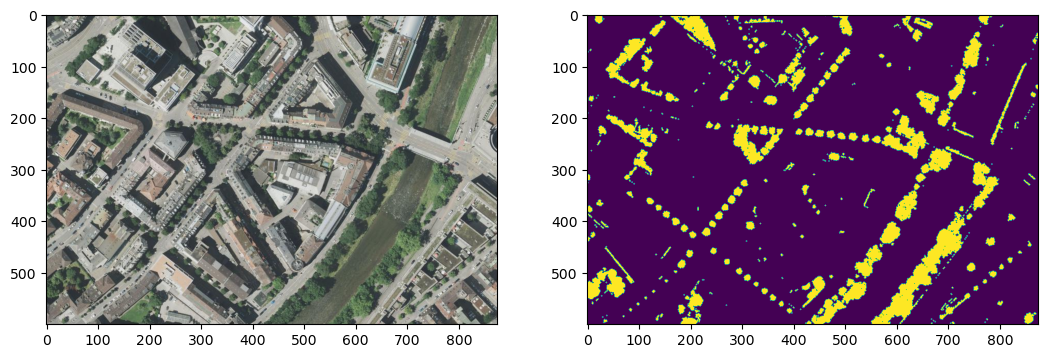

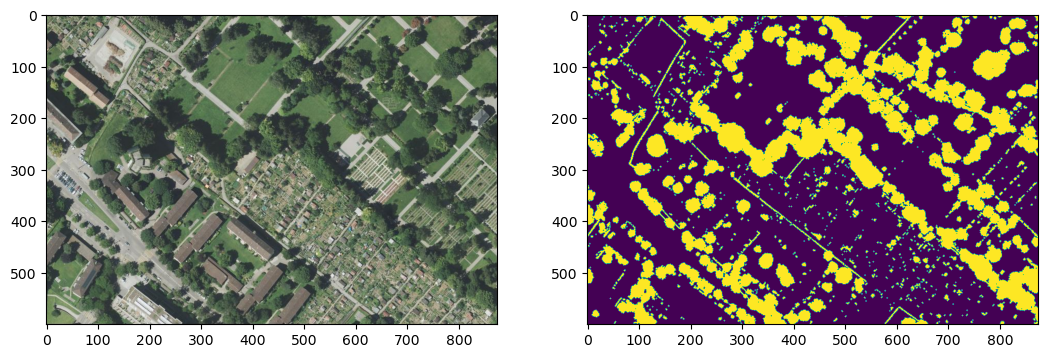

In [ ]:
for train_filepath, response_filepath in zip(train_filepaths, response_filepaths):
    fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
    with rio.open(train_filepath) as src:
        plot.show(src.read(), ax=axes[0])
    with rio.open(response_filepath) as src:
        plot.show(src.read(), ax=axes[1])

Note that accuracy of the ground-truth masks is crucial to train a good classifier.


## Training the classifier

We can now proceed to the training of the classifier. In detectree, this can be done with the `train_classifier` method of the `ClassifierTrainer` class. The training of the classifier can be customized by providing a set of keyword arguments to the initialization of `ClassifierTrainer` (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.__init__) for more details). Note that the training of the classifier can take some time.

In [ ]:
clf = dtr.ClassifierTrainer().train_classifier(
    img_filepaths=train_filepaths, response_img_filepaths=response_filepaths
)

[########################################] | 100% Completed | 2.64 ss
[LightGBM] [Info] Number of positive: 422725, number of negative: 1152275
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6864
[LightGBM] [Info] Number of data points in the train set: 1575000, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268397 -> initscore=-1.002772
[LightGBM] [Info] Start training from score -1.002772


## Predicting tree/non-tree labels

Once the classifier has been trained, it can be used to predict the tree/non-tree labels from any given image. To that end, detectree provides the `Classifier` class, which features a `predict_img` method that can be (see [its documentation](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.ClassifierTrainer.__init__) for more details).

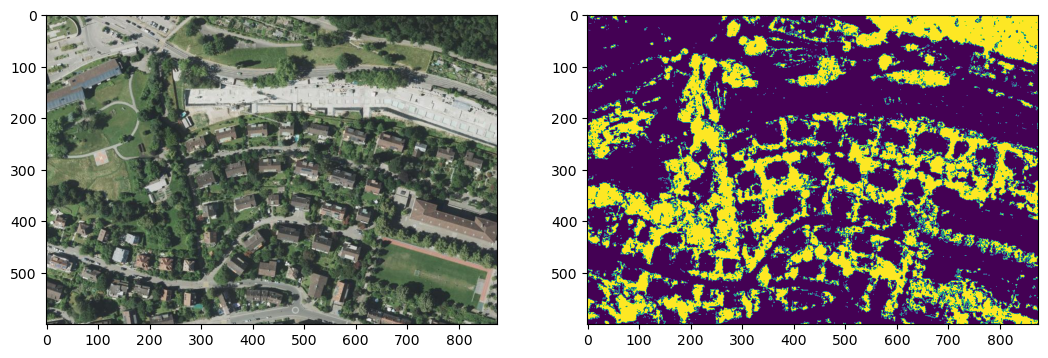

In [ ]:
test_filepath = random.choice(test_filepaths)

c = dtr.Classifier(clf=clf)
y = c.predict_img(test_filepath)

fig, axes = plt.subplots(1, 2, figsize=(2 * figwidth, figheight))
with rio.open(test_filepath) as src:
    plot.show(src.read(), ax=axes[0])
axes[1].imshow(y)

In order to classify multiple tiles in a single command, we might use [the `predict_imgs` method](https://detectree.readthedocs.io/en/latest/pixel_classification.html#detectree.Classifier.predict_imgs), which uses dask to classify the tiles in parallel.

## Validation

In order to evaluate the accuracy of the classifier, we can use the code below to build a confusion matrix, which uses the LIDAR dataset to compute the ground-truth masks.

In [ ]:
confusion_df = make_confusion_df.make_confusion_df(
    lidar_gdf,
    "data/raw/lidar",
    response_dir,
    img_filepaths=img_filepaths,
    frac=0.01,
    clf=clf,
)
confusion_df

[########################################] | 100% Completed | 127.01 s


predicted,0,255
actual,,
0,0.684859,0.102420
255,0.068255,0.144466


We can compute the accuracy, precision, recall and F1-score from the confusion matrix:

In [ ]:
accuracy, precision, recall, f1 = make_confusion_df.compute_metrics(confusion_df)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Accuracy: 0.8293250793650794
Precision: 0.5851519624735757
Recall: 0.6791350157446238
F1: 0.6286502892049937
